# imports

In [2]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import glob
import os
import pickle
import pandas as pd
import matplotlib
import random
import seaborn as sns

from NDNT import NDN
import NDNT.utils as utils # some other utilities
import ColorDataUtils.mattprintlib as mprint
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment

class Model:
    def __init__(self):
        pass
#from models import iter_core, cnn_core

device = torch.device("cuda:1")

datadir = '/Data/ColorV1/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load LGN models

In [10]:
models = {
    'lgn': [],
    'model': [],
    'LLs': []
}

path = '/Users/matt/projects/umd/ori_sfn/lgn2/'
for lgn in [3,4,5]: # LGN filters
    for i in range(15): # model iterations
        filename = path+'model_rotated_lgn'+str(lgn)+'_'+str(i)
        if not os.path.exists(filename+'.pkl'):
            print(filename)
            continue
        with open(filename+'.pkl', 'rb') as f:
            model = pickle.load(f)
        with open(filename+'.npy', 'rb') as f:
            LLs = np.load(f)
        models['model'].append(model)
        models['LLs'].append(np.mean(LLs))
        models['lgn'].append(lgn)

models = pd.DataFrame(models)

In [11]:
models

,lgn,model,LLs
0,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.028917
1,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029972
2,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029310
3,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029079
4,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.027944
5,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.030222
6,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.028174
7,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.028199
8,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029275
9,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029620


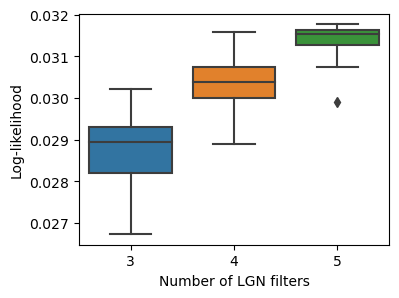

In [12]:
# plot LLs for lgn number (using bar and whisker plot)
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
sns.boxplot(x='lgn', y='LLs', data=models, ax=ax)
ax.set_xlabel('Number of LGN filters')
ax.set_ylabel('Log-likelihood')
plt.show()

In [13]:
model.networks[0].layers[0].get_weights().shape

(9, 9, 14, 5)

In [35]:
# get the top 5 models for each lgn number in a dataframe
top_models = []
for lgn in [3,4,5]:
    top_models.append(models[models['lgn']==lgn].sort_values('LLs', ascending=False).head(5))
# convert to dataframe
top_models = pd.concat(top_models)
top_models

,lgn,model,LLs
5,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.030222
1,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029972
9,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029620
2,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029310
8,3,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029275
23,4,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031578
16,4,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031464
28,4,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.030845
15,4,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.030768
20,4,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.030743


In [29]:
# get the list of models for each number of LGN filters
num_filters = 3
mdls = models[models['lgn'] == num_filters]['model'].values

# Hungarian algo

In [89]:
num_filters = 5

# align the filters based on distance (dot product)
mdls = models[models['lgn']==num_filters].sort_values('LLs', ascending=False).head(5)
mdls = mdls['model'].values
w = mdls[0].networks[0].layers[0].get_weights()
num_filters = w.shape[3]
wtmp_maxses = []
wtmp_minses = []
for i, model in enumerate(mdls):
    wtmp_maxs = []
    wtmp_mins = []
    w = model.networks[0].layers[0].get_weights()
    # TODO: align the filters based on distance (dot product)
    #       we can use the Hungarian algorithm
    for filt in range(num_filters):
        num_lags = w.shape[2]
        wtmp = np.squeeze(w[:, :, :, filt].reshape(-1, num_lags))
        bestlag = np.argmax(np.std(wtmp, axis=0))
        wmax = np.argmax(wtmp[:, bestlag])
        wmin = np.argmin(wtmp[:, bestlag])
        wtmp_max = wtmp[wmax, :]
        wtmp_min = wtmp[wmin, :]
        wtmp_maxs.append(wtmp_max)
        wtmp_mins.append(wtmp_min)
    wtmp_maxses.append(wtmp_maxs)
    wtmp_minses.append(wtmp_mins)
    
# normalize the filters before computing the dot product
# for i, (wtmp_maxs, wtmp_mins) in enumerate(zip(wtmp_maxses, wtmp_minses)):
#     for filt in range(num_filters):
#         wtmp_maxses[i][filt] = wtmp_maxses[i][filt] / np.linalg.norm(wtmp_maxses[i][filt])
#         wtmp_minses[i][filt] = wtmp_minses[i][filt] / np.linalg.norm(wtmp_minses[i][filt])
#         wtmp_maxses[i][filt] = wtmp_maxses[i][filt]
#         wtmp_minses[i][filt] = wtmp_minses[i][filt]
    
# starting from the first model, find its best match to the filters in the subsequent models
# create a distance matrix between its filters and the subsequent ones,
# then use the Hungarian algorithm to find the best match

from fastdtw import fastdtw
for mdl in range(0, 5):
    # create distance matrix
    dist_mat = np.zeros((num_filters, num_filters))
    for filt0 in range(num_filters):
        for filt1 in range(num_filters):
            # normalize the filters before computing the dot product
            normed_filt0 = wtmp_maxses[0][filt0] / np.linalg.norm(wtmp_maxses[0][filt0])
            normed_filt1 = wtmp_maxses[mdl][filt1] / np.linalg.norm(wtmp_maxses[mdl][filt1])
            #normed_filt0 = wtmp_maxses[0][filt0]
            #normed_filt1 = wtmp_maxses[mdl][filt1]
            # use dynamic time warping to determine the distance between the filters
            max_distance, max_path = fastdtw(normed_filt0, normed_filt1, dist=lambda x, y: np.dot(x, y))

            # normalize the filters before computing the dot product
            normed_filt0 = wtmp_minses[0][filt0] / np.linalg.norm(wtmp_minses[0][filt0])
            normed_filt1 = wtmp_minses[mdl][filt1] / np.linalg.norm(wtmp_minses[mdl][filt1])
            #normed_filt0 = wtmp_minses[0][filt0]
            #normed_filt1 = wtmp_minses[mdl][filt1]
            # use dynamic time warping to determine the distance between the filters
            min_distance, min_path = fastdtw(normed_filt0, normed_filt1, dist=lambda x, y: np.dot(x, y))
            #max_distance = np.dot(normed_filt0, normed_filt1)
            #min_distance = np.dot(normed_filt0, normed_filt1)
            
            dist_mat[filt0, filt1] = np.mean([max_distance, min_distance])
            
    # find the best match
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(-dist_mat)
    print(row_ind, col_ind)
    # reorder the filters in the subsequent model
    wtmp_maxses[mdl] = [wtmp_maxses[mdl][col_ind[i]] for i in range(num_filters)]
    wtmp_minses[mdl] = [wtmp_minses[mdl][col_ind[i]] for i in range(num_filters)]

# get best lag, it is the max of the wtmp_maxses and abs(wtmp_minses)
max_pos, max_pos_lag = np.max(wtmp_maxs[0]), np.argmax(wtmp_maxs[0])
max_neg, max_neg_lag = np.max(np.abs(wtmp_mins[0])), np.argmax(np.abs(wtmp_mins[0]))
max_lag = np.argmax([max_pos, max_neg])
max_lag = max_pos_lag if max_lag == 0 else max_neg_lag
max_lag

# get the best_lag per filter
best_lags = []
w = mdls[0].networks[0].layers[0].get_weights()
for filt in range(num_filters):
    num_lags = w.shape[2]
    wtmp = np.squeeze(w[:, :, :, filt].reshape(-1, num_lags))
    bestlag = np.argmax(np.std(wtmp, axis=0))
    best_lags.append(bestlag)
print(best_lags)

[0 1 2 3 4] [0 3 2 1 4]
[0 1 2 3 4] [1 4 2 3 0]
[0 1 2 3 4] [3 1 0 2 4]
[0 1 2 3 4] [0 1 4 3 2]
[0 1 2 3 4] [1 0 3 4 2]
[7, 10, 10, 10, 9]


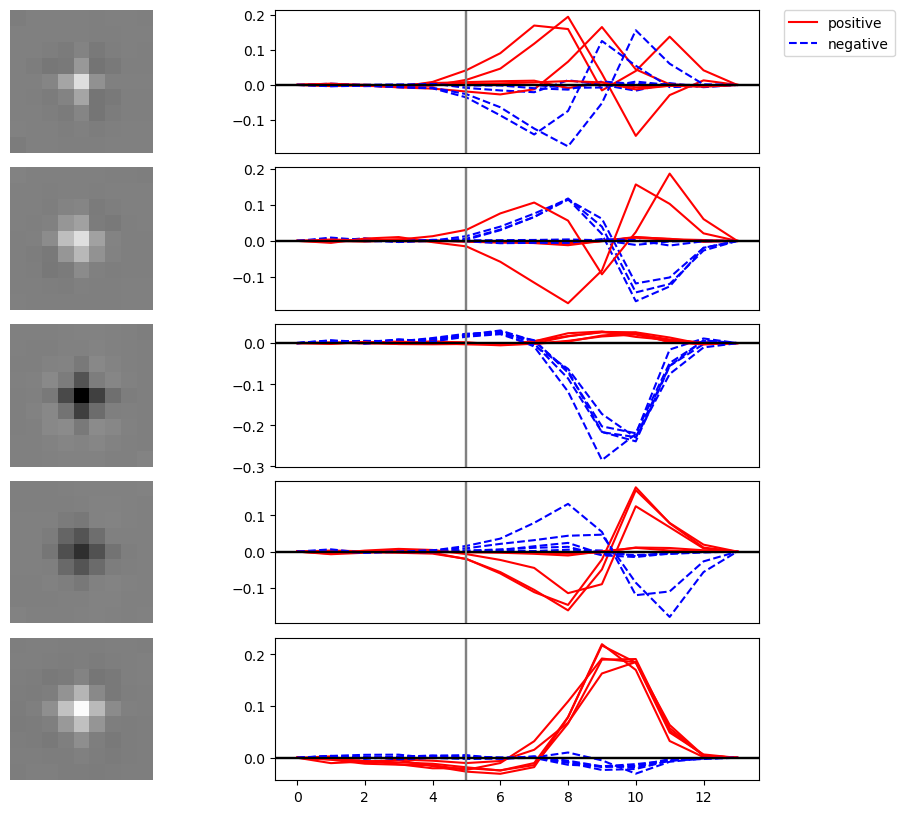

In [90]:
# plot the filters
rows = num_filters
fig = plt.figure(figsize=(10, 10))
grid = matplotlib.gridspec.GridSpec(rows,3, wspace=0.5, hspace=0.1)
max_im = mdls[0].networks[0].layers[0].get_weights()
max_w = np.max(np.abs(max_im))
for filt_num in range(num_filters):
    ax = plt.subplot(grid[filt_num, 0])
    # plot the filter spatial component
    ax.imshow(max_im[:, :, best_lags[filt_num], filt_num], cmap='gray', vmin=-max_w, vmax=max_w)
    ax.axis('off')

    ax = plt.subplot(grid[filt_num, 1:])
    for i, (wtmp_maxs, wtmp_mins) in enumerate(zip(wtmp_maxses, wtmp_minses)):
        ax.plot(wtmp_maxs[filt_num], '-', c='r', label=i)
        ax.plot(wtmp_mins[filt_num], '--', c='b', label=i)
        # plot the legend
        if filt_num == 0:
            # put legend outside of plot
            ax.legend(['positive', 'negative'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        if filt_num < num_filters-1:
            ax.set_xticks([])
        # plot the zero line
        ax.axhline(0, color='k')
        # plot the best lag
        ax.axvline(5, color=(.5, .5, .5))
        # plot the filter number

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_47311/1432856845.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(wtmp[wmax, :], 'b-', alpha=0.5, label='Model' + str(i), c=colors[i])


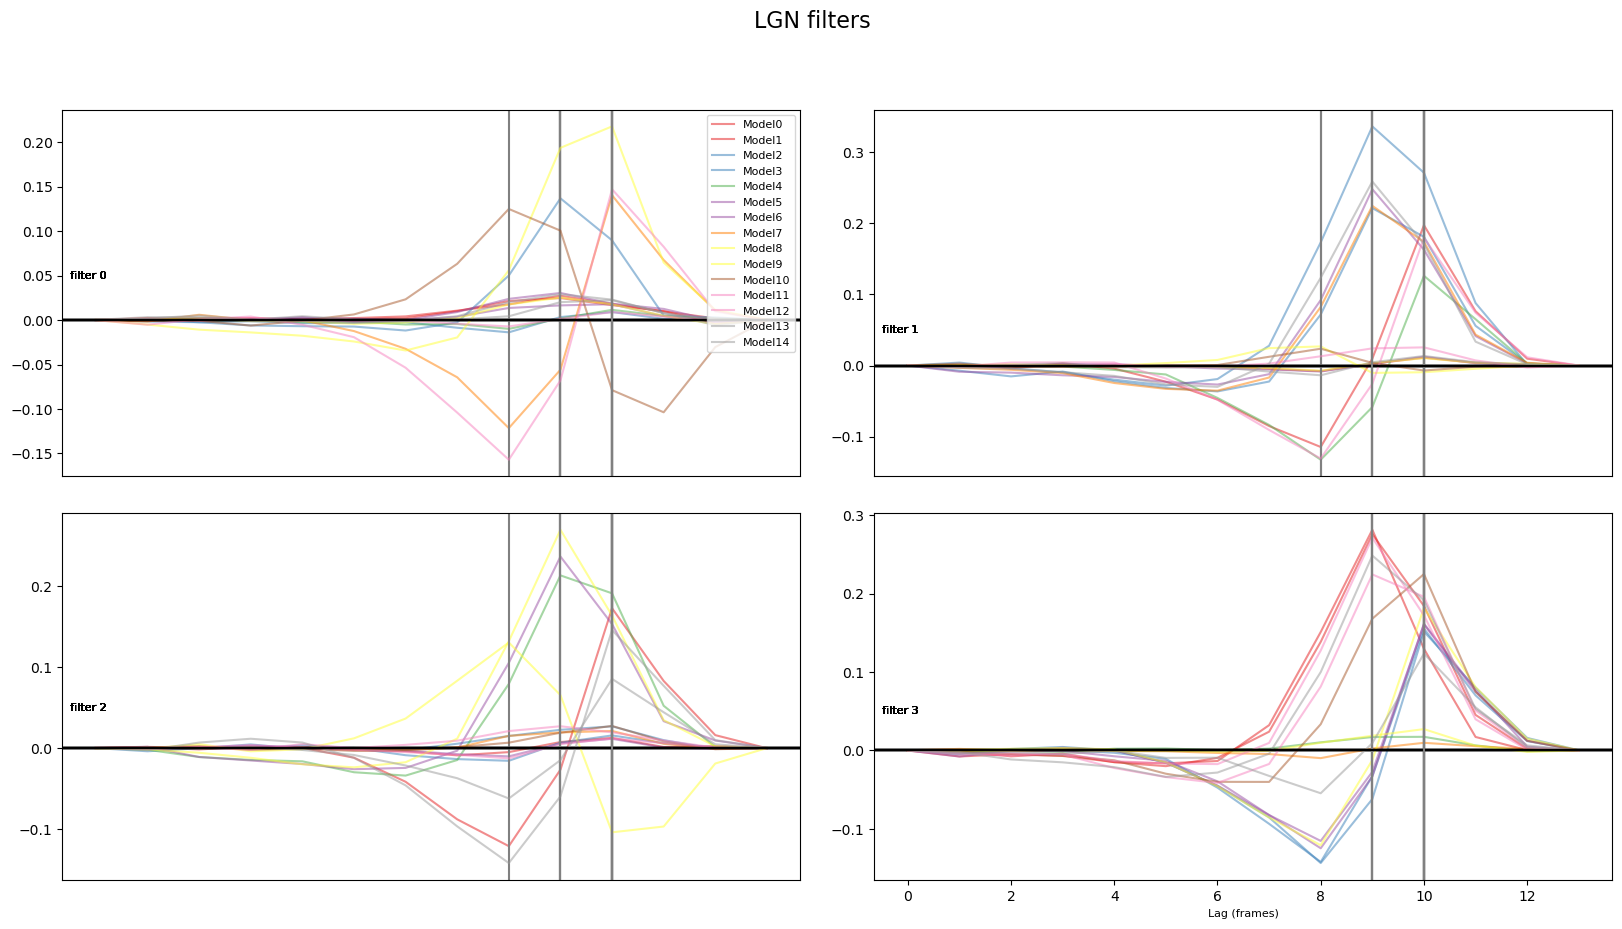

In [37]:
def plot_lgn(models, rows, cols, plot_min=False, figsize=(20, 10)):
    # get the weights for the first model
    w = models[0].networks[0].layers[0].get_weights()
    num_filters = w.shape[3]
    fig = plt.figure(figsize=figsize)
    grid = matplotlib.gridspec.GridSpec(
        rows, cols, 
        wspace=0.1, hspace=0.1)
    colors = plt.cm.Set1(np.linspace(0, 1, len(models)))
    for i, model in enumerate(models):
        w = model.networks[0].layers[0].get_weights()
        # TODO: align the filters based on distance (dot product)
        #       we can use the Hungarian algorithm
        for filt in range(num_filters):
            row,col = np.unravel_index(filt, (rows, cols))
            ax = plt.subplot(grid[row,col])
            num_lags = w.shape[2]
            wtmp = np.squeeze(w[:, :, :, filt].reshape(-1, num_lags))
            bestlag = np.argmax(np.std(wtmp, axis=0))
            wmax = np.argmax(wtmp[:, bestlag])
            wmin = np.argmin(wtmp[:, bestlag])
    
            if filt != num_filters - 1:
                # turn off x-axis
                ax.set_xticks([])
            # if np.sum(np.abs(wtmp[wmax, :])) > np.sum(np.abs(wtmp[wmin, :])):
            #     ax.plot(wtmp[wmax, :], 'b-', alpha=0.5, label='Model' + str(i), c=colors[i])
            # else:
            #     ax.plot(wtmp[wmin, :], 'b--', alpha=0.5, label='Model' + str(i), c=colors[i])
            ax.plot(wtmp[wmax, :], 'b-', alpha=0.5, label='Model' + str(i), c=colors[i])
            if plot_min:
                ax.plot(wtmp[wmin, :], 'b--', alpha=0.5, label='Model' + str(i), c=colors[i])
    
            ax.axhline(0, color='k')
            ax.axvline(bestlag, color=(.5, .5, .5))
            ax.text(-0.5, 0.05, f'filter {filt}', fontsize=8, verticalalignment='center')
            if filt == 0:
                ax.legend(loc='upper right', fontsize=8)
            if filt == num_filters - 1:
                ax.set_xlabel('Lag (frames)', fontsize=8)
    plt.suptitle('LGN filters', fontsize=16)
    # shift subplots down
    #fig.tight_layout()
    plt.show()
    
mdls = models[models['lgn'] == 4]['model'].values
plot_lgn(mdls, rows=2, cols=2)

# plot LGN image

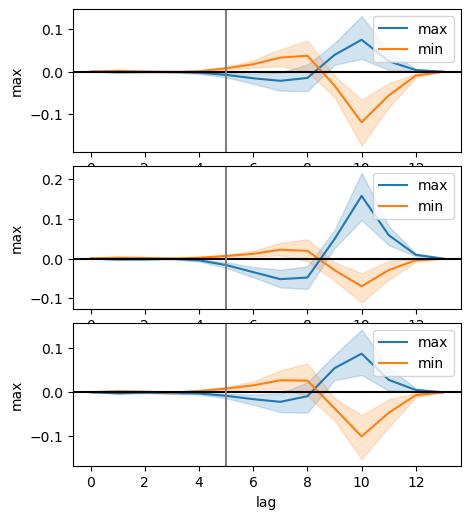

In [31]:
def plot_lgn_sns(models, figsize=(15, 8)):
    # get the weights for the first model
    w = models[0].networks[0].layers[0].get_weights()
    num_filters = w.shape[3]
    filt_dfs = []
    for filt in range(num_filters):
        filt_df = {
            'lag': [],
            'min': [],
            'max': []
        }
        for i, model in enumerate(models):
            w = model.networks[0].layers[0].get_weights()
            num_lags = w.shape[2]
            wtmp = np.squeeze(w[:, :, :, filt].reshape(-1, num_lags))
            bestlag = np.argmax(np.std(wtmp, axis=0))
            wmax = np.argmax(wtmp[:, bestlag])
            wmin = np.argmin(wtmp[:, bestlag])
            for lag in range(num_lags):
                filt_df['lag'].append(lag)
                filt_df['max'].append(wtmp[wmax, lag])
                filt_df['min'].append(wtmp[wmin, lag])
        filt_dfs.append(pd.DataFrame(filt_df))
    return filt_dfs

model_num = 3
mdls = models[models['lgn'] == model_num]['model'].values
filt_dfs = plot_lgn_sns(mdls)

# plot the data in a grid
fig = plt.figure(figsize=(5, 10))
grid = matplotlib.gridspec.GridSpec(5,1, wspace=0.1, hspace=0.1)
for filt_num in range(model_num):
    row,col = np.unravel_index(filt_num, (5,1))
    ax = plt.subplot(grid[row,col])
    sns.lineplot(data=filt_dfs[filt_num], x="lag", y="max", label='max')
    sns.lineplot(data=filt_dfs[filt_num], x="lag", y="min", label='min')
    # plot the legend
    plt.legend(loc='upper right')
    # plot the zero line
    ax.axhline(0, color='k')
    # plot the best lag
    ax.axvline(5, color=(.5, .5, .5))
    # plot the filter number
plt.show()

# 3-4-5 LGN plot

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_47311/1432856845.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(wtmp[wmax, :], 'b-', alpha=0.5, label='Model' + str(i), c=colors[i])


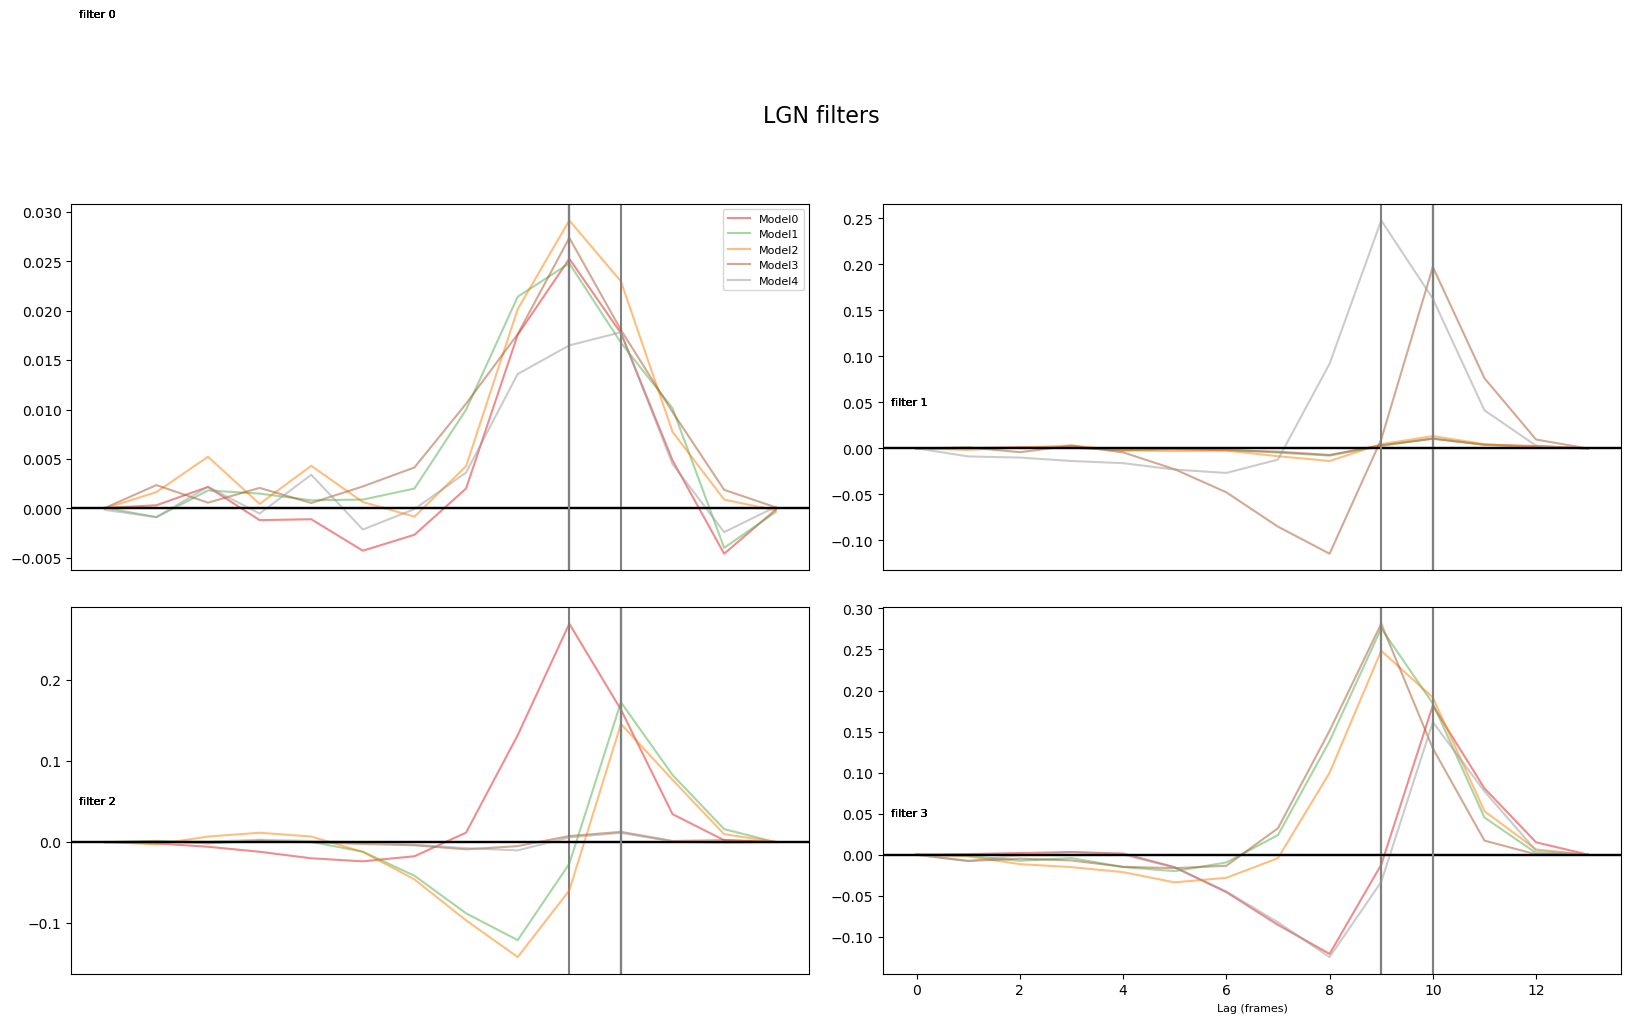

In [39]:


top_models_3 = models[models['lgn']==3].sort_values('LLs', ascending=False).head(5)
top_models_4 = models[models['lgn']==4].sort_values('LLs', ascending=False).head(5)
top_models_5 = models[models['lgn']==5].sort_values('LLs', ascending=False).head(5)

plot_lgn(top_models_4['model'].values, rows=2, cols=2)